In [ ]:
import pickle

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pyro
import pyro.distributions
import torch
from torch.distributions import constraints

az.style.use("arviz-doc")

* Taking 10 samples with 500 warmups is really slow. Repeat for 100 trials and it is really really slow.
* Will it affect the result if we take 10 * 100 = 1000 samples after warmup and split the chain up in pieces of 10
* Same for 100 and 1000
* For one chain R-hat cannot be computed
* 

In [2]:
class CustomDensity(pyro.distributions.TorchDistribution):
    # The domain of the custom PDF
    support = constraints.interval(torch.tensor(-3), torch.tensor(3))
    # Enforce that start value is within the support
    arg_constraints = {"start": support}

    def __init__(self, start=torch.tensor(0.0)):
        self.start = start
        super(pyro.distributions.TorchDistribution, self).__init__()

    # This is just used as a starting point for the MCMC sampler
    def sample(self, sample_shape=torch.Size()):
        return self.start

    # Return log of the unnormalized density
    def log_prob(self, x):
        return -(x**2) / 2 + torch.log(
            (
                (torch.sin(x)) ** 2
                + 3 * (torch.cos(x)) ** 2 * (torch.sin(7 * x)) ** 2
                + 1
            )
        )

In [3]:
# Pyro model
def model():
    x = pyro.sample("x", CustomDensity())

In [25]:
# Run HMC / NUTS

# Initial parameters for each chain
# initial_params = {
#     "x": torch.tensor([-2.0, 2.0, -1.0, 1.0])  # Shape [num_chains]
# }

nuts_kernel = pyro.infer.NUTS(model)
mcmc = pyro.infer.MCMC(
    nuts_kernel,
    num_samples=10000,
    num_chains=1,
    warmup_steps=500,
    # initial_params=initial_params,
)
mcmc.run()

Sample: 100%|██████████| 10500/10500 [00:27, 383.66it/s, step size=1.27e-01, acc. prob=0.912]


In [26]:
# Get the samples
samples = mcmc.get_samples()["x"]

# Calculate E(x^2)
print(torch.mean(samples**2).item())

0.9255746006965637


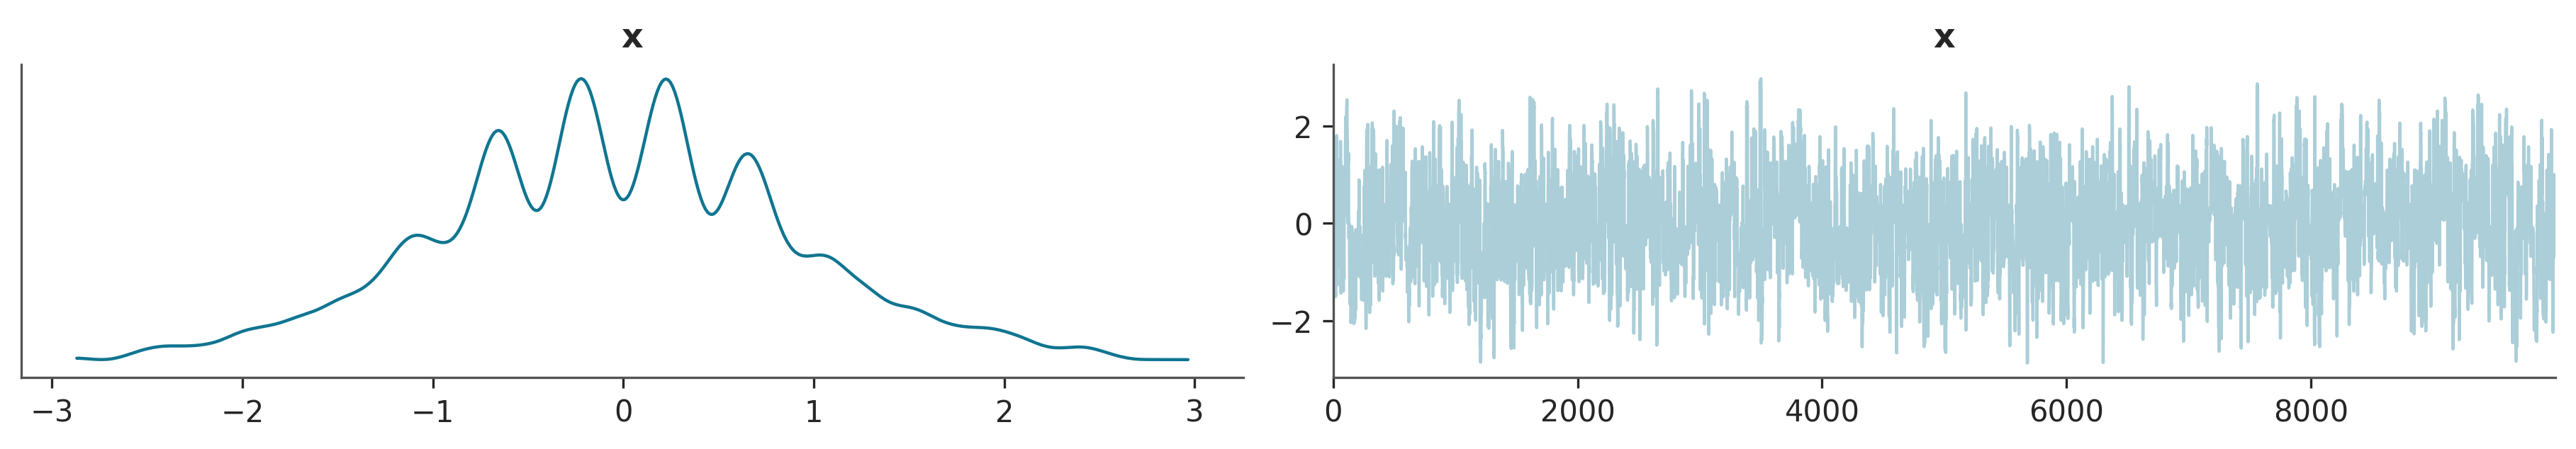

In [27]:
# TODO use arviz to summarize and investigate: plot
data = az.from_pyro(mcmc)

az.plot_trace(data, var_names=("x"))

plt.show()

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.037  0.961  -1.902    1.852      0.029     0.02    1121.0    1500.0   

   r_hat  
x    NaN  


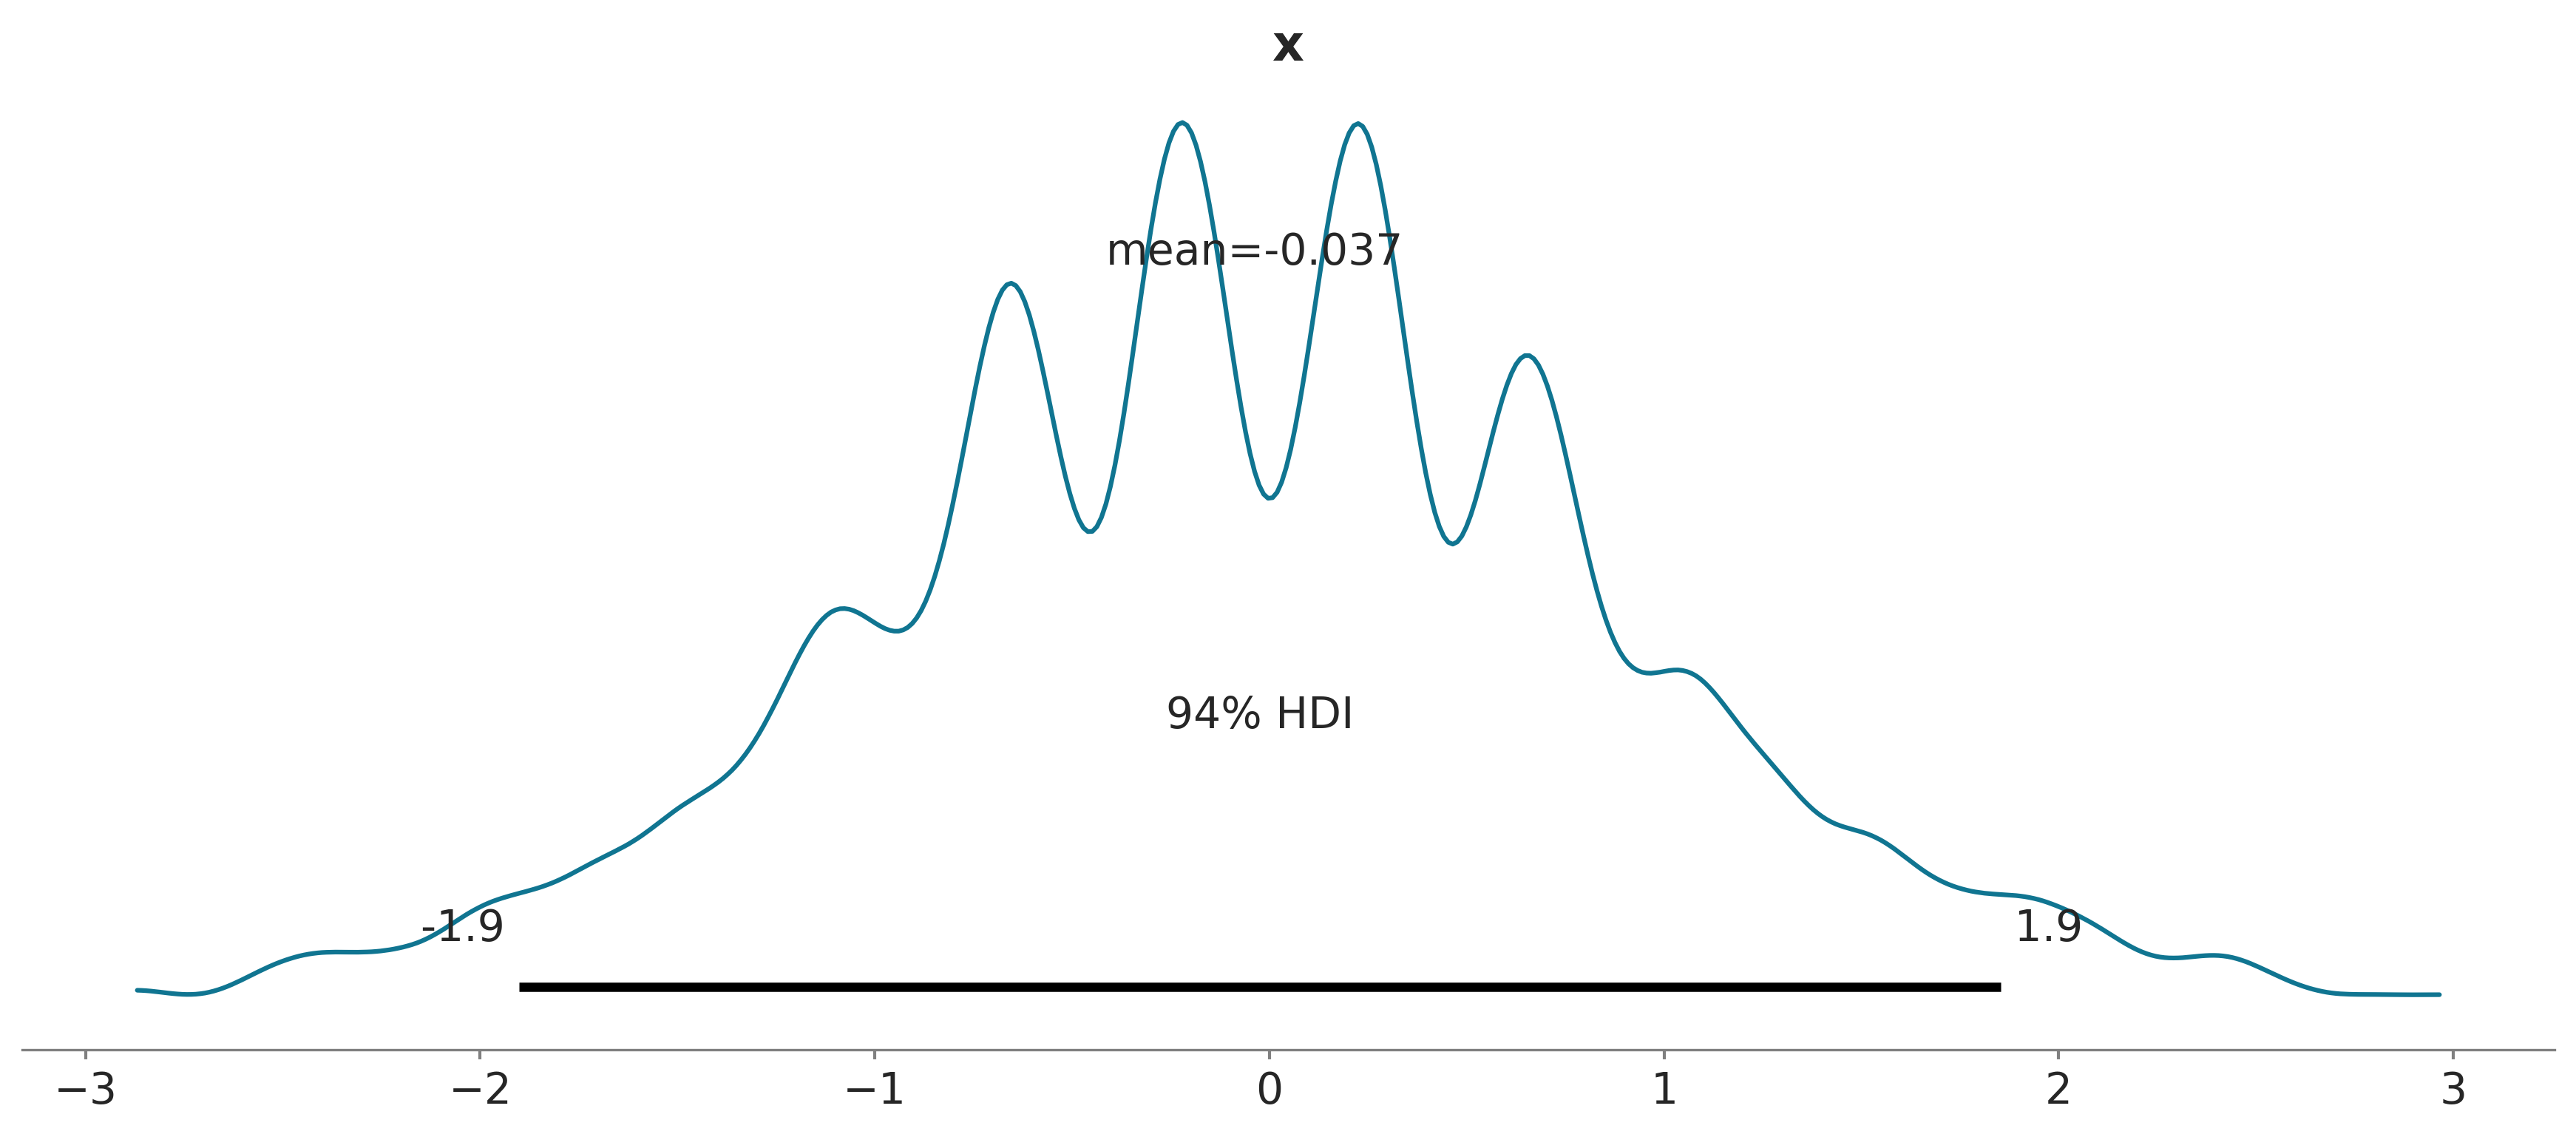

In [28]:
data = az.from_pyro(mcmc)
# ESS, r-hat
summary = az.summary(data)
print(summary)
# Density plot
az.plot_posterior(data)
plt.show()

In [ ]:
# HMC / NUTS
def HMC(n_samples):
    # num_chains = n_samples / 2

    nuts_kernel = pyro.infer.NUTS(model)

    mcmc = pyro.infer.MCMC(
        nuts_kernel,
        num_samples=n_samples,
        num_chains=1,
        warmup_steps=500,
    )
    mcmc.run()

    samples = mcmc.get_samples()["x"]

    expected_val = torch.mean(samples**2).item()
    return expected_val

In [20]:
with open("../week3/data.pkl", "rb") as f:
    data = pickle.load(f)

In [22]:
trials = 100
number_of_samples = [10, 100, 1000]

In [23]:
for trial in range(trials):
    for n_samples in number_of_samples:
        estimator = HMC(n_samples)
        # Create a string representation of q
        q_repr = "HMC/NUTS"
        data.append(
            {
                "trial": trial,
                "samples": n_samples,
                "sampling method": q_repr,
                "estimator": estimator,
            }
        )

Sample: 100%|██████████| 1500/1500 [00:02, 501.47it/s, step size=2.32e-01, acc. prob=0.742]


In [24]:
df = pd.DataFrame(data)

# Compute mean and standard deviation for each combination of n_samples and q
grouped = df.groupby(["samples", "sampling method"])["estimator"].agg(["mean", "std"])


print(grouped)

                                        mean       std
samples sampling method                               
10      HMC/NUTS                    1.105024  1.187799
        importance sampling norm    0.928537  0.357609
        rejection sampling norm     0.857527  0.375900
        rejection sampling uniform  0.942758  0.456646
100     HMC/NUTS                    0.931845  0.346276
        importance sampling norm    0.914220  0.131331
        rejection sampling norm     0.927552  0.131934
        rejection sampling uniform  0.915646  0.138565
1000    HMC/NUTS                    0.918129  0.107084
        importance sampling norm    0.910965  0.042440
        rejection sampling norm     0.913647  0.044586
        rejection sampling uniform  0.920091  0.035158


In [ ]:
# TODO make figures w.r.t. different sample sizes, samplers, etc.

In [36]:
# Python package versions used
%load_ext watermark
%watermark --a "Carsten Jørgensen"
%watermark --e "carstenj@gmail.com"
%watermark -m -v -i -iv


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Carsten Jørgensen

Email: carstenj@gmail.com

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.28.0

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 11
Architecture: 64bit

arviz     : 0.20.0
matplotlib: 3.9.2
pandas    : 2.2.3
torch     : 2.5.0
pyro      : 1.9.1

